<a href="https://colab.research.google.com/github/hisabojp/git_tutorial/blob/master/1_6_nn_tutorial_jp_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

「torch.nnを用いたディープラーニングモデルの実装方法」
===============================================================
【原題】What is torch.nn really?

【原著】[fast.ai](https://www.fast.ai) よりJeremy Howard（謝辞： Rachel Thomas、Francisco Ingham）

【元URL】https://pytorch.org/tutorials/beginner/nn_tutorial.html

【翻訳】電通国際情報サービスISID AIトランスフォーメーションセンター　徳原 光

【日付】2020年11月24日

【チュトーリアル概要】

手書き文字のデータセットである「MNISTデータセット」に対して、ニューラルネットワークの分類システムを実装しながら、torch.nn、torch.optim、 Dataset、DataLoaderといったPyTorchの各モジュール、クラスの役割を説明し、実装方法と、ディープラーニングモデルの訓練の流れについて解説します。


---

日本語訳注：

Google ColaboratoryでGPUモードにするには、上部メニューの「ランタイム」から「ランタイムタイプを変更」を選択し、ハードウェアアクセラレーターをGPUにします。

本ファイルは始めからGPUモードになっています。

---

PyTorchには、ニューラルネットワークの作成と訓練を支援するように、綿密に設計されたモジュールやクラスとして、[torch.nn](https://pytorch.org/docs/stable/nn.html)、[torch.optim](https://pytorch.org/docs/stable/optim.html)、[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)、[DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)などが用意されています。


これらのモジュールの性能を十分に発揮し、問題に合わせてカスタマイズするためには、これらが実際にどのような処理を行っているのか正確に理解する必要があります。

その理解を深めるために、まずはこれら機能を利用せず、最も基本的なPyTorch Tensorのみを使用して、MNISTデータセットに対し、シンプルなニューラルネットワークを訓練します。


そして、``torch.nn``、``torch.optim``、 ``Dataset``、``DataLoader``の順に各モジュールを追加していき、それぞれが実際に何をしているのか、さらにコードをより簡潔かつ柔軟にするためにどのような役目を果たしているのかを確認していきます。

本チュートリアルは、実行環境にPyTorch がインストールされていて、学習者が基本的なTensor(テンソル)の扱いに慣れていることを前提としています。

（Numpy配列での演算に慣れている方は、PyTorch TensorをNumpyと同様の操作で利用することができます。）

MNISTデータの用意
----------------

手書きの数字の白黒画像（0から9まで）で構成された古典的なデータセットである、[MNISTデータセット](vue-js-etude-1.firebaseio.com/person.json)を使用します。

ファイルのパスを扱うために、[pathlib](https://docs.python.org/3/library/pathlib.html) （Python 3標準ライブラリの一部）を使用し、[requests](https://requests.readthedocs.io/en/master/)を用いてデータセットをダウンロードします。

（日本語訳注：requestsはURLで指定した宛先とHTTPによる通信を行うためのPythonライブラリです）

<br>

モジュールは使用する際にインポートするように記述しますので、各時点でどのモジュールが使用されているかを正確に確認することができます。

<br>

**※日本語訳注**：本チュートリアルの翻訳時上記のURLからデータセットをダウンロードすることができないという現象が発生しています（2020年11月24日）。
代替手段を5セルほど下に記載します。


In [ ]:
%matplotlib inline

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

# このコードだとファイルのダウンロードに失敗する
# if not (PATH / FILENAME).exists():
#         content = requests.get(URL + FILENAME).content
#         (PATH / FILENAME).open("wb").write(content)

# ファイルのダウンロード
URL = "https://github.com/pytorch/tutorials/raw/main/_static/mnist.pkl.gz"
response = requests.get(URL)
with open((PATH / FILENAME).as_posix(), "wb") as f:
    f.write(response.content)

このデータセットはNumpy配列と同じ形式であり、データを連結して格納するためにPickleを利用しています。

（日本語訳注：PickleはPythonの標準ライブラリで、オブジェクトを連結し、保存したり、保存したファイルを読み込んだりする用途で用いられます）

In [ ]:

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")


それぞれの画像のサイズは 28 x 28 ですが、1次元に平坦化されて要素数が784 (= 28×28)の数値配列として保存されています。

まずデータを2次元の画像に変換し、画面に表示してみましょう。


(50000, 784)


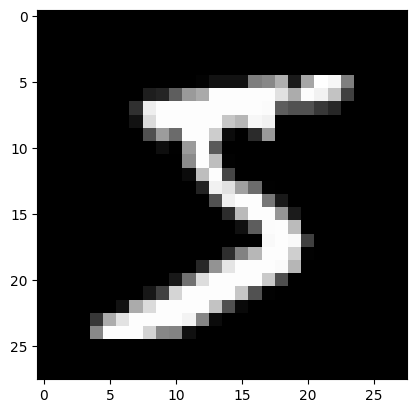

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorchはNumpy配列ではなく``torch.tensor``を利用するので、データを変換する必要があります。



In [ ]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


 (torch.nnなしで）ニューラルネットワークを構築
-----------------------------------

まず、PyTorch Tensorによる演算以外は何も利用せずに、ニューラルネットワークのモデルを実装してみましょう。

ここからは、ニューラルネットワークの基本知識を前提として解説します。

 (本チュートリアルの前提知識は、[fast.aiのコース](https://course.fast.ai/)で学習することができます。)



PyTorchには、各要素が乱数や0で初期化されたTensorを生成するメソッドが用意されています。

これらで生成したテンソルを単純な線形モデルの重みとバイアスを実装する際に利用することができます。

生成されたものは普通のTensorですが、PyTorchに対して勾配計算が必要であることを伝える、特別な特徴も保有しています。

この特徴によってPyTorchはTensorに行われたすべての演算を記録し、誤差逆伝播中に自動的に勾配を計算できます。

重みに対しては、初期化作業に対して勾配が追跡されることを防ぐために、**初期化した後に**``requires_grad``を設定します。

(注意：PyTorchにおいて、末尾の``_``は、操作がインプレース、すなわち上書き実行されることを意味します。)

**注釈**

重みの初期化は[Xavierの初期値](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)(1/sqrt(n)を掛ける)を使用しています。

（日本語訳注：Xavierの初期値では、乱数で決定した値に、その層が持つノードの数nの平方根の逆数を掛けた値を各々のパラメータの初期値として使用します）

In [ ]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

PyTorchが持つ勾配の自動計算機能により、Pythonの標準的な関数（または呼び出し可能なオブジェクト）をモデルとして利用することができます。

それでは、シンプルな線形モデルを作成するために、単純な行列の乗算とブロードキャストを使った加算を定義してみましょう。

さらに、活性化関数も必要になるので、``log_softmax``関数を定義して使用します。

<br>

PyTorchでは、たくさんの損失関数や活性化関数といった関数があらかじめ用意されていますが、Pythonのコードによって簡単にオリジナルな関数を定義できることも覚えておいてください。


PyTorchは独自に定義された関数をもとに高速にGPUやベクトル化されたCPUコードを自動で生成します。



In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

上記のコードで、``@``は行列積を表しています。

一つのバッチデータ（この場合は64枚の画像）に対して、各関数が実行されることになります。





以下のコードは、順伝播の経路を表していますが、乱数で定義された重みをそのまま使用しているので、予測値はランダムな結果よりも優れたものは得られないことに注意してください。

In [ ]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5846, -2.2352, -2.6326, -2.0638, -2.0107, -2.8734, -2.6340, -2.2946,
        -2.1802, -1.9467], grad_fn=<SelectBackward0>) torch.Size([64, 10])


このようにTensor変数``preds``には、値だけではなく勾配情報も含まれていて、誤差逆伝播を行う際に利用することができます。



損失関数として、負の対数尤度を出力する関数（`nll`関数）を実装してみましょう（ここでも標準的なPythonのコードを用います）。



In [ ]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

先ほど実装したランダムなモデルで損失の値を確認してみましょう。

モデルが改善されていることは、誤差逆伝播を行った後に確認することができます。

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3411, grad_fn=<NegBackward0>)


モデルの予測精度を計算する関数も実装しておきましょう。

それぞれの予測において、出力が最大となった要素のラベルが正解のラベルと一致すれば、予測が正しかったことになります。



（日本語訳注）：0から9までの手書き文字を予測する場合、モデルから出力されるTensorは10種類の値を持ち、それぞれの値は数字の0から順に対応付けられています。

<br>

入力した画像が9を表していた場合、出力されたTensorが持つ最後（10番目）の値が最大であった時、モデルが正しく画像から対応する数字を予測したと言えます。

In [ ]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

ランダムなモデルの精度を確認して、損失が減少すると予測精度が改善されるのか確認してみます。

In [ ]:
print(accuracy(preds, yb))

tensor(0.0156)


これで、学習を繰り返し行う準備が整いました。

それでは次に、イテレーションごとに次の手順を実施します。



- データのミニバッチを``bs``（バッチサイズ）の大きさで選択する
- モデルを用いて予測を行う
- 損失を計算する
- ``loss.backward() ``はモデルの勾配を更新します。この場合では重みとバイアスの勾配を算出しています。

そして、これらの勾配を利用して重みとバイアスを更新します。

更新処理は、勾配の計算に更新処理が記録されることを防ぐために、コンテキストマネージャである``torch.no_grad() ``のwithブロック内で実行します。

PyTorch の Autograd がどのように操作を記録するかについて、詳細を学びたい方は[こちら](https://pytorch.org/docs/stable/notes/autograd.html)をご覧ください。


さらに、次の訓練の準備をするために、勾配をゼロに設定する必要があります。

そうしなければ、実行したこれまでの操作に対して勾配が累積されて記録されてしまいます（つまり、``loss.backward()``は既存の勾配を、新しく算出したものに上書きするのでなく、すでに保存されているものに加算しています）。


**ポイント**

下記のコードの``set_trace()``のコメントアウトを解除することで、Pythonに搭載されている標準デバッガを使用して各ステップごとの変数の値を確認することができます。

In [ ]:
from IPython.core.debugger import set_trace

lr = 0.05  # learning rate
epochs = 10  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

これで、最小限の大きさのニューラルネットワークをスクラッチで実装し訓練することに成功しました（このケースでは、隠れ層がないので単なるロジスティクス回帰になります）。

では、モデルの損失と精度を算出して、その前に得た結果と比較してみましょう。

損失は減少し、正解率が向上すると予想しましたが、実際にそうなることが見てとれると思います。

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3694, grad_fn=<NegBackward0>) tensor(0.8750)


torch.nn.functionalを利用
------------------------------

それでは、PyTorchの``nn``クラスの利点を利用してコードをリファクタリングすることで、これまで実装した内容と同じモデルを簡潔かつ柔軟なコードで実装したいと思います。

ここから各ステップにおいて、コードをより短く、分かりやすく、そして柔軟に記述していきます。

簡単に行える最初のステップとして、手書きの活性化関数と損失関数を``torch.nn.functional``のものに置き換えることでコードをより簡潔なものにします。

（``torch.nn.functional``は慣例的に``F``という省略名をつけられてインポートすることになっています。）

<br>

このモジュールには``torch.nn``ライブラリのすべての関数が含まれています（クラス自体はその他のライブラリに含まれています）。

他の損失関数や活性化関数と同様に、プーリング関数といったニューラルネットワークを実際に実装するにあたって、有用な関数もこの``torch.nn.functional``には含まれています。

（畳み込み層や線形層の実装に利用できる関数も存在しますが、通常は他のライブラリのクラスを利用したほうがいいでしょう。）



負の対数尤度損失と対数ソフトマックス活性化を使用している場合は、PyTorchが持つこれらの関数を組み合わせた``F.cross_entropy``を使用することができます。

つまり、活性化関数さえも定義しなくてもよいのです。

In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias


``model``関数で、``log_softmax``を使用する必要がなくなったことに注意してください。

loss_funcでの損失や正解率が変化していないことを確認してみましょう。

In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.3694, grad_fn=<NllLossBackward0>) tensor(0.8750)


nn.Moduleを使用したコードのリファクタリング
-----------------------------
次は``nn.Module``と``nn.Parameter``を利用して訓練の繰り返し処理の実装をよりシンプルで簡単なものにします。

まずは、（状態を追跡可能なクラスである）``nn.Module``を継承しサブクラスを定義します。

この場合は順伝播のために重みとバイアスとメソッドを保持するクラスを作成します。

``nn.Module``には便利な属性変数やメソッド
（``.parameters()``や``.zero_grad()``のような）が数多く含まれています。



**注意**

このnn.Module（頭文字が大文字のM）はPyTorch特有の概念で、これからよく使用することになります。

Pythonにおける、インポートしたプログラムファイルを指すmodule（頭文字が小文字のm）の概念と混同しないように気をつけてください。


In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

関数を使う代わりに、今回はオブジェクトを使用するので、まずはmodelを定義したクラスからインスタンスを生成する必要があります。



In [ ]:
model = Mnist_Logistic()

モデルの定義と同様の方法で損失を計算することができます。

``nn.Module``オブジェクトは、あたかも関数のように（呼び出し可能で）使用できます。

その裏では、PyTorchが自動的に順伝播のメソッドを呼び出しています。



In [ ]:
print(loss_func(model(xb), yb))

tensor(2.2527, grad_fn=<NllLossBackward0>)


これまでは下記のコードのように、一つ一つの各パラメータの値を、変数名を記述することで更新し、それぞれの勾配を手動で0に初期化する必要がありました：





```
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()
```



``nn.Module``を継承し、``model.parameters()``と``model.zero_grad()``を利用することで（どちらもPyTorchの``nn.Module``で定義されています）、これらの処理をより簡潔に実装することが可能です。

特に複雑なモデルの場合では、更新処理の際にパラメータが抜けてしまうといった間違いを防止できます：



```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```



続いて、上記のパラメータ更新を含む訓練処理を、後ほど実行できるように``fit``関数として定義しておきます。

In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

損失が減ったことを再確認しましょう。


In [ ]:
print(loss_func(model(xb), yb))

tensor(0.3705, grad_fn=<NllLossBackward0>)


nn.Linearを使用したリファクタリング
-------------------------

引き続きコードのリファクタリングをしていきます。

先ほど手動で``self.weights``と``self.bias``を定義して初期化し、``xb  @
self.weights + self.bias``という演算処理を実装しましたが、その代わりに、これらのすべての機能を担うことのできるPyTorchの[**``nn.Linear``**](https://pytorch.org/docs/stable/nn.html#linear-layers)を使用します。

Pytorchには様々な種類の定義済みレイヤーが存在し、多くの場合、これらの既成のレイヤー（モジュール）を使用することでコードを簡素化し、高速化することができます。



In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

モデルをインスタンス化し、以前と同じ方法で損失を計算します：


In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3794, grad_fn=<NllLossBackward0>)


これまでと同様に``fit``メソッドを使うことができます：



In [ ]:
fit()

print(loss_func(model(xb), yb))

tensor(0.3601, grad_fn=<NllLossBackward0>)


optimを使用したリファクタリング
------------------------------

PyTorchには、様々な最適化アルゴリズムを持つパッケージである``torch.optim``も存在します。

``step``メソッドを利用して各パラメータを更新するように実装します。

``step``メソッドを用いることで、これまで手動で実装していたパラメータ更新（最適化）のステップを置き換えることができます。



```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```



上記のコードの代わりに下記のコードを実行してください：



```
opt.step()
opt.zero_grad()
```



（ただし、次のミニバッチの勾配を計算する前に、勾配を0に初期化するoptim.zero_grad()を呼び出す必要があります。）

In [ ]:
from torch import optim

ここでモデルとオプティマイザを作成するための関数を定義しておき、あとで再利用できるようにします。



In [ ]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3214, grad_fn=<NllLossBackward0>)
tensor(0.3659, grad_fn=<NllLossBackward0>)


Datasetを利用したリファクタリング
------------------------------




PyTorchにはデータセットに関する抽象クラスも存在します。

``__len__``関数（Pythonの標準の``len``関数によって呼び出される）と、渡されたインデックスに対応するデータを返す``__getitem__``関数を持つクラスであればどんなものでもDatasetクラスとして利用できます。

[こちらのチュートリアル](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)では、Datasetのサブクラスとして独自の``FacialLandmarkDataset``クラス（顔の輪郭のデータセット）を実装する例を紹介しています。

PyTorchの[TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)はTensorをラップしています。

（日本語訳注：クラスをラップするとは、新規に定義した別のクラスを通して間接的にラップされたクラスの機能を利用するために、ラップ対象のクラスを包むクラスを新規に定義し、新規クラス内で対象のクラスの操作を実装することを意味しています）




インデックスの長さと指定の仕方を定義することで、Tensorの一つ目の次元に沿って、繰り返し、インデックス付け、スライスを行う方法を提供します。

（日本語訳注：DatasetがTensorの最初の次元をもとにデータの操作を行うのは、最初の次元が個々のデータのインデックス（何番目のデータなのか）を表しているためです。例えば、MNISTデータセットの場合は、1次元目がデータのインデックス、2次元目がx座標、3次元目がy座標になります）



これにより、訓練を行う際に、独立変数と従属変数の両方に同じ行でアクセスすることが容易になります。

（日本語訳注：この例において独立変数とはモデルに入力する画像データxであり、従属変数はその画像に対応するラベルyのことを指します）


In [ ]:
from torch.utils.data import TensorDataset

一つの``TensorDataset``のインスタンスを得る際には、引数に``x_train``と``y_train``の組を指定します。

こうすることによって反復処理の際、一度の操作でデータのスライスを行えるようになります。

In [ ]:
train_ds = TensorDataset(x_train, y_train)

これまでは、x と y の値をそれぞれミニバッチごとに取得しなければなりませんでした。:


```
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```
TensorDatasetを用いることで、一つの操作で``x_train``と``y_train``両方のデータを同時に取得することができます：
```
xb,yb = train_ds[i*bs : i*bs+bs]
```




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.3705, grad_fn=<NllLossBackward0>)


DataLoaderを用いたリファクタリング
------------------------------

PyTorchの``DataLoader``はバッチの管理を担っています。

どのような``Dataset``からでも``DataLoader``は作成可能です。

``DataLoader``はバッチのイテレーション（繰り返し処理）をより簡単にしてくれます。

``DataLoader``を利用すれば、毎回``train_ds[i*bs : i*bs+bs]``と記述する必要はなくなり、自動的にそれぞれのミニバッチを生成することができます。



In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

これまでは、反復処理においてバッチ（xb, yb）を得るためにこのように記述していました：



```
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```


一方``DataLoader`` を用いると、以下のようにバッチ（xb, yb）を自動的に取得できるので反復処理を簡潔に実装することができます：



```
for xb,yb in train_dl:
    pred = model(xb)
```




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.3737, grad_fn=<NllLossBackward0>)




バリデーションを追加する
-----------------------

ここまでの内容では、 訓練データの使用方法を学ぶために、簡単に解決できる問題をモデルに学習させていました。

現実問題では、**常に**、過学習を起こしていないかを確認する必要があるので、[validation set](https://www.fast.ai/2017/11/13/validation-sets/)（検証用のデータセット）を使用しなくてはなりません。



バッチ内で相関が現れてしまうことや過学習を防ぐには、訓練データをあらかじめシャッフルしておくことが重要です。

一方で、検証のためのデータセットはシャフルの有無は関係なく、損失は同じになります。


余分な時間がかかってしまうので、検証データはシャッフルしないようにしましょう。

検証時は誤差逆伝播による訓練ステップが存在しないためメモリをそれほど使用しません（勾配を保存する必要がないため）。そこで検証セットには学習セットの2倍のバッチサイズを使用します。

こうすることにより、より大きなバッチサイズを使用して損失をより迅速に計算することができます。



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

各エポックが終了するごとに、検証として損失を算出します。

（``NN.BatchNorm2d``や``NN.Dropout``などのレイヤの適切な動作を保証するためには、訓練前には、``model.train()``を、そして推論の前には``model.eval()``を呼び出し、ネットワークのモードを切り替える必要があることに注意して下さい。）



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3820)
1 tensor(0.3345)
2 tensor(0.3157)
3 tensor(0.3037)
4 tensor(0.2973)
5 tensor(0.2911)
6 tensor(0.2865)
7 tensor(0.2825)
8 tensor(0.2800)
9 tensor(0.2795)


fit関数とget_data関数の実装
----------------------------------

ここで、また少しリファクタリングをしてみましょう。

<br>

学習セットの損失の計算と検証セットの損失の計算という似たようなプロセスを2回行っているので、この損失の計算の操作をまとめ、独自の関数 ``loss_batch`` として定義します。

<br>

訓練セットに対しては、この関数にオプティマイザを渡すことで、誤差逆伝播による訓練を実施することができます。

検証セットに対しては、オプティマイザを渡さないのでモデルが訓練されることはありません。



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit``関数はモデルを訓練し、各エポックごとに訓練損失と検証損失を計算するために必要な操作を実行します。



In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` 関数は、訓練セットと検証セットのデータローダを返します。

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

これで、データローダの取得からモデルのフィッティングまでの全てのプロセスがたった3行のコードで実行できるようになりました：



In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.38489156701564786
1 0.3368971110343933
2 0.3179638211488724
3 0.30540217789411545
4 0.2992494594812393
5 0.2930638169288635
6 0.2891748028755188
7 0.2868509804368019
8 0.2852094702243805
9 0.2804236898779869


この基本的な3行のコードを応用すれば様々なモデルを訓練することができます。

これらの関数を使用して、畳み込みニューラルネットワーク(CNN)を訓練できるか試してみましょう。

CNNモデルへの変更
-------------

これから3層の畳み込み層を持つニューラルネットワークを構築します。

これまでに定義した関数はどれもモデルの形については何も前提としていないので、CNNの訓練の際にも、変更を加えず使用できます。

畳み込み層としてPyTorchの定義済みクラス[Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)を使用します。

3つの畳み込み層を持つCNNを定義します。

各畳み込み層は活性化関数のReLUに接続し。最終的にアベレージプーリングを実施します。

（`view`はPyTorchにおける、Numpyの`reshape`のようなものであることに注意してください。）



In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

[Momentum](https://cs231n.github.io/neural-networks-3/#sgd)は確率的勾配降下法を応用した最適化アルゴリズムで、過去の更新も考慮に入れており、多くの場合でより高速にモデルを訓練させることができます。



In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.41185467212200166
1 0.22361810079962016
2 0.17921202181875706
3 0.1738851021319628
4 0.16029679223001003
5 0.14865417637825012
6 0.14687735542953015
7 0.15294533051550388
8 0.13684962940514087
9 0.14871391568779946


nn.Sequentialの利用
------------------------

`torch.nn`には、nn.Moduleの他にもう一つ、[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) という便利なクラスが存在します。

`Sequential` オブジェクトは、あらかじめ登録されたモジュールを順番に実行します。

これにより、ニューラルネットワークをさらに簡単に実装することができます。

与えられた関数から簡単に**カスタムレイヤー**を定義することで`Sequential`を利用することができます。

例えば、PyTorchには`view`レイヤがないので、ネットワークの実装のために`view`レイヤを定義する必要があることがあります。

下記の`Lambda`関数で、`Sequential`を用いてネットワークを定義する際に使えるレイヤを定義します。



（日本語訳注）
最新のPyTorchでは、[`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)が追加されて、最後のフラット化（1次元化）をする以下のオリジナルモジュールの役割を担います。

その実装も追記しておきます。

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

シーケンシャルを用いて作成したモデルはシンプルに利用することができます：



In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.5731389441013336
1 0.4704306062221527
2 0.43647236523628236
3 0.45641438417434693
4 0.4012393455028534
5 0.401154176568985
6 0.4004936940193176
7 0.38245248165130613
8 0.37350717678070067
9 0.39853732266426084


In [ ]:
# 日本語訳注：最新のnn.Flatten()を使用した場合

model = nn.Sequential(
    Lambda(preprocess),  # これはnn.Flatten()では対応できないので、このまま
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    # Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Flatten()  # 上記Lambdaの代わり
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3807900171279907
1 0.2717717319488525
2 0.21381081998348236
3 0.1926133973300457
4 0.184767905408144
5 0.1881239752471447
6 0.15623238807916642
7 0.15003757560253142
8 0.13942352396249771
9 0.12436602845937014


DataLoaderのラップ
-----------------------------

今回実装したCNNはシンプルですが、MNISTにしか使用することができません。

理由は

 - 入力が28×28のベクトルに制限されている
 - 最終的なCNNのグリッドサイズが（アベレージプーリングのカーネルサイズにより）4×4に指定されている


ためです。




```
# これはコードとして書式設定されます
```


この２つの制約を取り除き、任意の2次元シングルチャンネル画像で動作するようにしましょう。

まず、最初に実装したラムダ層を取り除き、データの前処理をジェネレータへと移します。

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

続いてですが、`NN.AvgPool2d`を`NN.AdaptiveAvgPool2d`に置き換えることで、入力テンソルのサイズではなく、出力したいテンソルの任意のサイズを定義することができます。

この変更によって、モデルはどんなサイズの入力に対しても対応することができます。



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

試しに`fit`関数を使用してみましょう：



In [ ]:
%%time

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3393591950416565
1 0.23681851541996002
2 0.23274375675320624
3 0.20111894656419754
4 0.17500387798547745
5 0.15872182080447675
6 0.15621308937966824
7 0.16810878595113754
8 0.16304067859053611
9 0.12687546251416207
CPU times: user 52 s, sys: 101 ms, total: 52.1 s
Wall time: 52.4 s


GPUの利用
---------------

CUDA対応のGPUにアクセスする環境をお持ちの方は、GPUを用いてコードの実行を高速化することができます（クラウドサービスから一時間につき0.5ドル程度でレンタルすることも可能です）。

まず、PytorchでGPUが動作しているかどうかを確認してください：





日本語訳注：

Google ColaboratoryでGPUモードにするには、上部メニューの「ランタイム」から「ランタイムタイプを変更」を選択し、ハードウェアアクセラレーターをGPUにします。

本ファイルは始めからGPUモードになっています。

In [ ]:
print(torch.cuda.is_available())

True


次に、デバイスオブジェクトを作成します：



In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

データのバッチをGPUに移動させるために前処理を再定義してみましょう：



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

最後に、モデルをGPUに移動させます。

（日本語訳注：モデルをGPUに置きなおしたので、オプティマイザーも定義し直します）





In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

実行速度が速くなったことを確認してください。

In [ ]:
%%time

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.13911741957068444
1 0.1275185433626175
2 0.13562582704424858
3 0.1386361155182123
4 0.12235836689770221
5 0.1217835092842579
6 0.11099787874668837
7 0.12808961267471314
8 0.13646752904355525
9 0.11071072020232678
CPU times: user 17.5 s, sys: 395 ms, total: 17.9 s
Wall time: 18.8 s


まとめ
-----------------

本チュートリアルでは、PyTorchを使用し、様々なタイプのモデルの訓練に応用できる、データ処理と訓練の流れを解説しました。

モデルの訓練をどれくらい簡単にできるのか確認するために、サンプルのノートブックで MNISTデータを用いたデータセットを訓練しました。

もちろん、データ拡張、ハイパーパラメータのチューニング、訓練のモニタリング、転移学習など、追加したい機能はたくさんあります。

これらの機能は、[fastaiライブラリ](https://docs.fast.ai/)を利用することで簡単に実装できます。

本チュートリアルで解説したPyTorchの設計と同じアプローチで開発されており、自分が実装するモデルをさらに進化させたいと考えている方には良いステップになるかと思います。

本チュートリアルの最初に、torch.nn、torch.optim、 Dataset、DataLoaderそれぞれについて、例を挙げて説明していくと記しました。

最後に、本チュートリアルで学んだことを確認します。

 - **``torch.nn``**

   + ``Module``: 現在の状態（ニューラルネットワークの層の重みなど）を保持する機能を持ち、関数のように呼び出すことができます。ネットワークが持つ``Parameter``も管理していて、重みの更新のために勾配の保持や初期化を繰り返し行います。
   + ``Parameter``：Tensorのラッパークラスになります。Tensorが``requires_grad`` 属性を持っている場合、誤差逆伝播時に`Module`に更新対象であることを知らせます。
   + ``functional``：誤差関数や活性化関数などの関数を持つモジュールです（慣例として``F``という略称でインポートされます）。畳み込み層や線形層といった状態を持つモジュールの状態なし版レイヤーも同様にこのモジュールに含まれています。
 - **``torch.optim``**：`SGD`などの複数のオプティマイザーが含まれていて、逆伝播の際に``Parameter``の重みを更新します。
 - **``Dataset``**：TensorDatasetのようなPytorchで提供されているクラスを含む抽象インターフェースです。メソッドとして``__len__``や``__getitem__``を保持しています。
 - **``DataLoader``**：任意の``Dataset``を受け取り、データのバッチを返すイテレータを生成することができます。

